In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
#create engine to connect and talk to the sql database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
last_date_measurement = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_measurement = last_date_measurement[0]
last_date_measurement


'2017-08-23'

In [15]:
# Design a query to retrieve the last 12 months of precipitation data 
one_year_ago = dt.datetime.strptime(last_date_measurement, '%Y-%m-%d') - dt.timedelta(days=365)
last_12_months = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).all()

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
last_date_measurement = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_measurement = last_date_measurement[0]
last_date_measurement
print("Date queried:", one_year_ago)

Date queried: 2016-08-23 00:00:00


In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_precipitation_df = pd.DataFrame(last_12_months, columns=['date', 'station','precipitation'])
last_year_precipitation_df['date'] = pd.to_datetime(last_year_precipitation_df['date'], format='%Y-%m-%d')
last_year_precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date

last_year_precipitation_df = last_year_precipitation_df.sort_values(by=['date'], ascending=True)
last_year_precipitation_df = last_year_precipitation_df.groupby(['date', 'station']).mean() # since each station has at most one measurement per day the mean (of one) is just the measurement
last_year_precipitation_df


precipitation
date       station                   
2016-08-24 USC00513117           2.15
           USC00514830           2.28
           USC00516128           1.45
           USC00517948            NaN
           USC00519281           2.15
           USC00519397           0.08
           USC00519523           1.22
2016-08-25 USC00513117           0.08
           USC00514830           0.00
           USC00516128           0.11
           USC00517948           0.00
           USC00519281           0.06
           USC00519397           0.08
           USC00519523           0.21
2016-08-26 USC00513117           0.03
           USC00514830           0.02
           USC00517948           0.04
           USC00519281           0.01
           USC00519397           0.00
           USC00519523           0.00
2016-08-27 USC00513117           0.18
           USC00514830           0.02
           USC00516128            NaN
           USC00519281           0.12
           USC00519397           0.00
           USC00519523           0.00
2016-08-28 USC00513117           0.14
           USC00514830           0.14
           USC00516128           2.07
           USC00519281           0.60
...                               ...
2017-08-16 USC00514830           0.00
           USC00516128           0.42
           USC00519281           0.12
           USC00519523           0.07
2017-08-17 USC00514830           0.00
           USC00516128           0.13
           USC00519281           0.01
           USC00519523           0.05
2017-08-18 USC00514830           0.00
           USC00516128            NaN
           USC00519281           0.06
           USC00519397           0.00
2017-08-19 USC00514830           0.00
           USC00516128           0.09
           USC00519397           0.00
           USC00519523            NaN
2017-08-20 USC00514830           0.01
           USC00516128            NaN
           USC00519397           0.00
2017-08-21 USC00514830           0.02
           USC00516128           0.56
           USC00519397           0.00
           USC00519523            NaN
2017-08-22 USC00516128           0.50
           USC00519397           0.00
           USC00519523           0.00
2017-08-23 USC00514830           0.00
           USC00516128           0.45
           USC00519397           0.00
           USC00519523           0.08

[2223 rows x 1 columns]

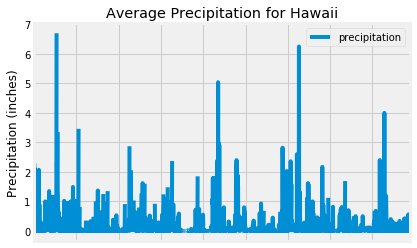

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

ax = last_year_precipitation_df.plot()
ax.xaxis.set_major_formatter(plt.NullFormatter()) # removes the dates from the x axis
plt.title("Average Precipitation for Hawaii")
plt.ylabel("Precipitation (inches)")
plt.xlabel("") 

# Save plot

plt.savefig("Output/Average Precipitation by Date.png", index=False, header=True)


In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Measurement.station).distinct().count()
print(f' {station_query} stations available')


 9 stations available


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count_query = session.query(Measurement.id, Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

station_count_query_df = pd.DataFrame(station_count_query, columns=['station id', 'station','observations'])
station_count_query_df


,station id,station,observations
0,12188,USC00519281,2772
1,1,USC00519397,2724
2,2725,USC00513117,2709
3,9519,USC00519523,2669
4,16939,USC00516128,2612
5,5434,USC00514830,2202
6,14960,USC00511918,1979
7,7636,USC00517948,1372
8,9008,USC00518838,511


In [23]:
# Station id number 12188 has the most observations (2772).
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

station_USC00519281_min = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

print(f'Station id 12188 minimum recorded temperature was {station_USC00519281_min}')


Station id 12188 minimum recorded temperature was [(54.0,)]


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
